Threshold and Subject-level Accuracy Analysis on RNAseq data

Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann, F Krastev

The main objective of the notebook is to simulate the variation for a given subject at different levels of relative standard deviation (RSD) of Transcripts Per Million (TPM) and then to demonstrate how the score varies.

We have three main outputs from the notebook.
Output 1: Scatter plot showing the simulated classifier scores vs the original classifier scores for all subjects.
Output 2: File containing the subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold for further analysis.
Output 3: File containing the False Positives, False Negatives, True Positives and True Negatives across 243 subjects at a given %RSD for further analysis.
Output 4: v-plot od classifier scores vs accuracies (agreement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel(
    "C:/Users/filip/OneDrive/Desktop/Molecular Stethoscope/Summer/ClusterMarkers_1819ADcohort.xlsx",
    sheet_name=1,
)
# setting index row name to the gene id
myDF = myDF.set_index("gene_id")
myDF2 = pd.read_excel(
    "C:/Users/filip/OneDrive/Desktop/Molecular Stethoscope/Summer/ClusterMarkers_1819ADcohort.xlsx",
    sheet_name=0,
)

Step 1: Data prep

In [2]:
# Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:, "Coeff"].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex="^\d+")

In [3]:
# group columns by patient id
grouped_cols = Patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = Patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

Step 2: Computing Zscores and RSD from TPM data

In [4]:
Patients_df["Mean"] = Patients_df.mean(axis=1)
Patients_df["Std"] = Patients_df.iloc[:, :-1].std(axis=1)
Patients_df["RSD"] = (Patients_df["Std"] / Patients_df["Mean"]) * 100  # New code Filip

Patients_df.head()
# print(Patients_df.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
0,40.167869,43.221009,92.130259,36.867336,64.314305,63.696200,41.183321,35.534550,36.171542,191.524541,...,9.274524,14.666869,40.936737,299.701309,17.106801,7.189015,10.098540,53.121500,79.676321,149.988840
1,4.669515,8.401576,8.044477,7.796848,4.318270,7.806746,9.211167,12.195125,10.564085,10.079085,...,11.573087,12.342026,10.625224,7.469338,11.927871,16.497740,14.550720,10.787571,3.842277,35.617624
2,91.808686,52.448546,77.172398,32.860140,29.747566,52.015815,34.804606,130.916750,140.893862,58.207067,...,38.826779,37.958158,43.614536,33.142251,46.494429,40.536438,47.586401,65.698961,83.616990,127.272926
3,44.561230,8.633877,20.823619,7.644599,7.040536,12.787137,9.176064,42.415771,53.226069,14.426345,...,11.595814,7.649485,5.971085,3.887344,15.568394,14.297212,13.878777,16.675735,21.333007,127.928438
4,3.803395,2.503695,7.236350,3.961408,5.700403,8.033717,8.790777,10.042520,14.269996,3.171475,...,1.144207,2.506974,5.519857,0.000000,6.095647,2.254747,2.472533,5.991910,7.390991,123.349508


In [5]:
rsd = Patients_df.loc[:, "RSD"]
rsd

0      149.988840
1       35.617624
2      127.272926
3      127.928438
4      123.349508
          ...    
962     49.674531
963     35.969073
964     29.273699
965     56.620656
966     39.737068
Name: RSD, Length: 967, dtype: float64

In [6]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x - x["Mean"]) / x["Std"]

In [7]:
# Computing and storing zscores
Patients_df_zScore = Patients_df.apply(lambda x: z_score(x), axis=1)
Patients_df_zScore.head()
# print(Patients_df_zScore.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
0,-0.162578,-0.124259,0.489590,-0.204002,0.140478,0.132721,-0.149833,-0.220730,-0.212735,1.737066,...,-0.550314,-0.482636,-0.152928,3.094769,-0.452013,-0.576489,-0.539972,0.0,0.333284,1.215761
1,-1.592300,-0.620985,-0.713924,-0.778373,-1.683716,-0.775797,-0.410279,0.366333,-0.058165,-0.184392,...,0.204440,0.404566,-0.042253,-0.863611,0.296777,1.486142,0.979406,0.0,-1.807599,6.462328
2,0.312254,-0.158466,0.137214,-0.392729,-0.429953,-0.163641,-0.369475,0.779959,0.899278,-0.089598,...,-0.321372,-0.331760,-0.264114,-0.389355,-0.229673,-0.300926,-0.216613,0.0,0.214287,0.736381
3,1.307153,-0.376968,0.194435,-0.423341,-0.451657,-0.182281,-0.351552,1.206583,1.713323,-0.105442,...,-0.238125,-0.423112,-0.501788,-0.599465,-0.051907,-0.111495,-0.131109,0.0,0.218313,5.215050
4,-0.296106,-0.471955,0.168373,-0.274727,-0.039441,0.276256,0.378686,0.548047,1.120024,-0.381604,...,-0.655893,-0.471511,-0.063869,-0.810704,0.014036,-0.505638,-0.476171,0.0,0.189296,15.878465


In [8]:
Patients_df = Patients_df.set_index(["Mean", "Std", "RSD"])
Patients_df.head()

,,,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5666,5668,5669,5672,5673,5683,5702,5706,5767,5784
Mean,Std,RSD,,,,,,,,,,,,,,,,,,,,,
53.121500,79.676321,149.988840,40.167869,43.221009,92.130259,36.867336,64.314305,63.696200,41.183321,35.534550,36.171542,191.524541,...,7.241628,28.617401,7.164479,9.274524,14.666869,40.936737,299.701309,17.106801,7.189015,10.098540
10.787571,3.842277,35.617624,4.669515,8.401576,8.044477,7.796848,4.318270,7.806746,9.211167,12.195125,10.564085,10.079085,...,9.157797,8.628283,11.588698,11.573087,12.342026,10.625224,7.469338,11.927871,16.497740,14.550720
65.698961,83.616990,127.272926,91.808686,52.448546,77.172398,32.860140,29.747566,52.015815,34.804606,130.916750,140.893862,58.207067,...,21.998621,24.373721,30.112225,38.826779,37.958158,43.614536,33.142251,46.494429,40.536438,47.586401
16.675735,21.333007,127.928438,44.561230,8.633877,20.823619,7.644599,7.040536,12.787137,9.176064,42.415771,53.226069,14.426345,...,6.930561,5.301323,12.477355,11.595814,7.649485,5.971085,3.887344,15.568394,14.297212,13.878777
5.991910,7.390991,123.349508,3.803395,2.503695,7.236350,3.961408,5.700403,8.033717,8.790777,10.042520,14.269996,3.171475,...,10.451834,0.944750,7.553130,1.144207,2.506974,5.519857,0.000000,6.095647,2.254747,2.472533


In [9]:
# rsd_array = np.repeat(rsd, 243)

In [10]:
patient_id = list(Patients_df_zScore.columns.values)
patient_id = patient_id[0:243]
# patient_id

Step 3: Defining Monte Carlo simulation and classifier functions using RSD

In [11]:
# np.random.seed(46215423)


# SImulation using gene-specific RSD
def RSD_simulation(subject, rsd, coefficient):
    score = 0
    subject_list = list(subject)
    for i in range(len(subject_list)):
        std = rsd[i] / 100 * subject_list[i]
        std = np.abs(std)
        sum_number = (coefficients[i]) * int(
            np.random.normal(subject_list[i], std, size=1)
        )
        score = score + sum_number
    return score


# Sampling function performing the Monte Carlo simulations
def Simulation(means, rsd, coefficients):
    std = [rsd / 100 * val for val in means]
    std = np.abs(std)
    return np.sum(
        np.multiply(
            coefficients, np.random.normal(means, std, size=(1, len(coefficients)))
        )
    )


# Function to perform anti-logit operation on the linear score
def cl_score(linear_score, gamma=0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score


# Function to calculate subject wise mean and rsd of simulated scores
def run_sim_one_patient_mean_sd(col):
    temp_Sim = [RSD_simulation(col, rsd, coefficients) for _ in range(numRuns)]
    return [np.mean(temp_Sim), np.std(temp_Sim)]


# Function to calculate the classifier score for each simulation of "num_runs" simulations, corresponding to each subject
def run_sim_one_patient(col, num_runs):
    temp_Sim = np.asarray(
        [cl_score(RSD_simulation(col, rsd, coefficients)) for _ in range(num_runs)]
    )
    return temp_Sim


# This score is the classifer linear score we want to compare with the simulated scores
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

Step 4: (Hyperparameters) We decide on number of simulations per subject (num_runs), assumed variation on TPM counts (uncertainty), and a classification threshold (thresh) ---¶ num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and rsd determined by the variable 'uncertainty'.

In [13]:
num_runs = 100
uncertainty = 25
thresh = 0.04874941

Step 5: Defining a function that plots the uncertainty around the threshold, and returns the figure, false positive count, false negative count, and number of subjects with unreliable classification for the specified variation and threshold.

In [14]:
def plot_uncert_at_thresh(num_runs, thresh):
    """The purpose of this function is to produce 2 things based on %RSD (uncertainty), threshold (thresh), number of MC simulations (num_runs) :
    1. Figure to show the scattering based on classifier scores of simulations against subject.
    2. False Positves/Negatives

    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code
        will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  A scatter plot will be produced using simulation scores on y-axis and subject scores on x-axis, two perpendicular lines passing the thresholds on x and y axis
     will  categorize the scatter dots into FP, FN , TP and TN.


    Example input: sub_accuracy(400, 50, 0.87)
    """

    false_pos = 0  # counter, stores number of points on second quadrant
    false_neg = 0
    num_subj_unreliable = np.zeros(
        243
    )  # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    fig = plt.figure(figsize=(10, 10))
    # for i in range(243):
    for i in range(243):
        scores = run_sim_one_patient(Patients_df_zScore.iloc[:, i], num_runs)
        y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, i]))
        x_data = np.ones_like(scores) * y_0
        y_data = scores
        colour = np.zeros_like(x_data)
        for j in range(len(x_data)):
            if x_data[j] > thresh and y_data[j] < thresh:
                colour[j] = 1
                false_neg = false_neg + 1
                num_subj_unreliable[i] = 1
            elif x_data[j] < thresh and y_data[j] > thresh:
                colour[j] = 2
                false_pos = false_pos + 1
                num_subj_unreliable[i] = 1
        plt.scatter(x_data, y_data, c=colour, cmap="Dark2_r", alpha=0.15, s=100)
    plt.axvline(x=thresh, color="g", linestyle="--")
    plt.axhline(y=thresh, color="g", linestyle="--")
    # plt.xlim([0.425, 0.575])
    # plt.ylim([0.425, 0.575])
    plt.xlabel("Classifier score", fontsize=24)
    plt.ylabel("Simulated scores", fontsize=24)
    plt.title("Uncertainty around threshold", fontsize=28)
    # Below are the labels of agreement and disagreement
    A = plt.scatter([0], [0], alpha=0)  # dummy plot for legend
    B = plt.scatter([0], [0], alpha=0)  # dummy plot for legend
    plt.text(0, 0.8, "A", fontsize=20)
    plt.text(0, 0, "B", fontsize=20)
    plt.text(0.8, 0, "B", fontsize=20)
    plt.text(0.8, 0.8, "A", fontsize=20)
    plt.legend([A, B], ["A : Agreement", "B : Disagreement"])
    # plt.savefig('figures/uncert_around_thresh_25_RSD.png')

    return [fig, false_pos, false_neg, (np.sum(num_subj_unreliable))]

In [16]:
### Check that random seeding is working by running this cell several times... it is working.
np.random.seed(78987765)
scores = run_sim_one_patient(Patients_df_zScore.iloc[:, 1], 10)
print(scores)
len(scores)

[0.0779078  0.1123961  0.00842997 0.00816423 0.029475   0.14050311
 0.01721497 0.01618124 0.2944037  0.02661264]


10

[<Figure size 1000x1000 with 1 Axes>, 157, 1, 43.0]

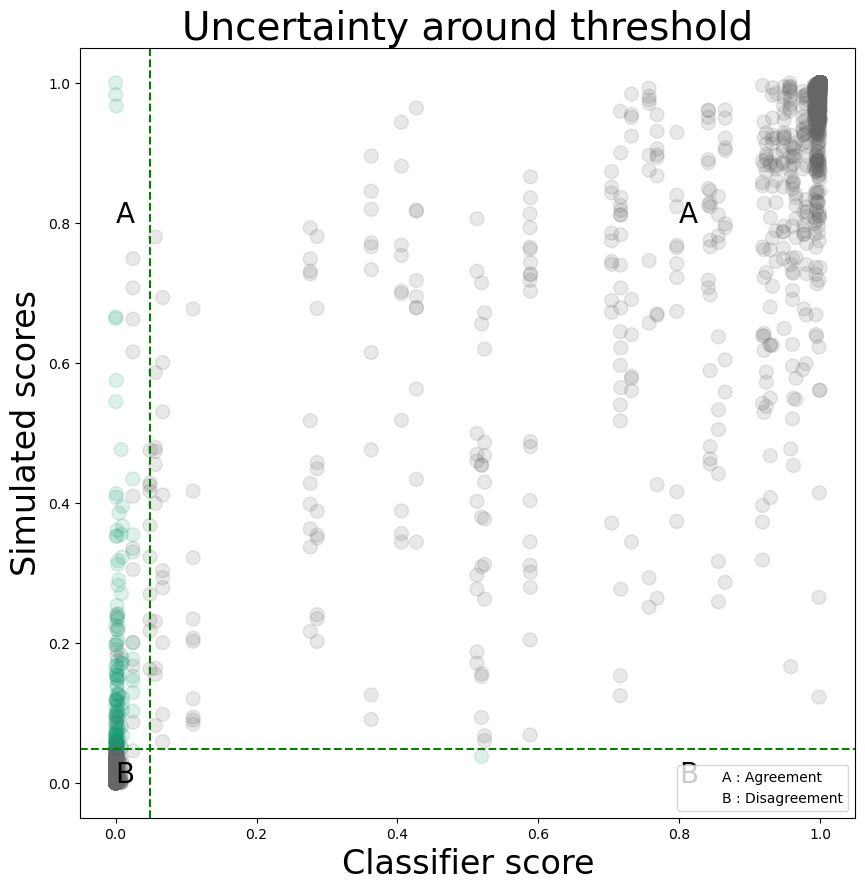

In [17]:
plot_uncert_at_thresh(10, thresh)

In [18]:
def sub_accuracy(thresh, num_runs):
    """The purpose of this function is to calculate 2 things based on %RSD (uncertainty_range), threshold (thresh), number of MC simulations (num_runs) :
    1. subject accuracy based on number of simulations : this info is provided in a dataframe called "accuracy_df"
    2. True Positives/Negatives, False Positves/Negatives: this info is provided in a dtatframe called "false_pos_df"

    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  the process 2-7 will be repeated for each %RSD input.


    Example input: sub_accuracy([20, 40, 50], 0.87, 400)  -> note that uncertainty_range should be given in a form of a list even if giving single value.
    """

    np.random.seed(46215423)
    global real_score
    global accuracy_df
    global y_data
    global x_data
    global Sub_score
    global false_pos_df
    global fig
    global classification_df

    lin_score = np.zeros(243)
    real_score = np.zeros(243)
    accuracy = np.zeros(243)
    classification_series = []
    false_pos_df = pd.DataFrame(
        index=[
            "simulations in agreement with subject",
            "simulations in disagreement with subject",
            "Unreliable Subjects",
        ]
    )

    num_subj_unreliable = np.zeros(
        243
    )  # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    false_pos_series = []
    AD = 0
    NCI = 0
    Sub_score = pd.Series(real_score)

    accuracy_df = pd.DataFrame()

    FN = []
    FP = []
    TN = []
    TP = []

    for j in range(243):
        false_pos = 0  # counter, stores number of points on second quadrant
        false_neg = 0
        true_pos = 0
        true_neg = 0
        scores = run_sim_one_patient(Patients_df_zScore.iloc[:, j], num_runs)
        y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, j]))
        x_data = np.ones_like(scores) * y_0
        y_data = scores
        colour = np.zeros_like(x_data)
        false_neg = 0
        false_pos = 0
        for k in range(len(x_data)):
            if x_data[k] > thresh and y_data[k] < thresh:
                false_neg = false_neg + 1
                num_subj_unreliable[j] = 1
            elif x_data[k] < thresh and y_data[k] > thresh:
                false_pos = false_pos + 1
                num_subj_unreliable[j] = 1
            elif x_data[k] > thresh and y_data[k] > thresh:
                true_pos = true_pos + 1
            elif x_data[k] < thresh and y_data[k] < thresh:
                true_neg = true_neg + 1

        accuracy[j] = (num_runs - (false_neg) - (false_pos)) / num_runs
        real_score[j] = y_0
        lin_score[j] = linear_score(coefficients, Patients_df_zScore.iloc[:, j])

        FN.append(false_neg)
        FP.append(false_pos)
        TN.append(true_neg)
        TP.append(true_pos)
        unreliable_subjects = str(np.sum(num_subj_unreliable))

        disagreement = sum(FN) + sum(FP)
        agreement = sum(TN) + sum(TP)

        accuracy_df["Accuracy"] = accuracy * 100
        false_pos_df = [agreement, disagreement, unreliable_subjects]
        Sub_score = pd.Series(real_score)
        lin_subscore = pd.Series(lin_score)

        accuracy_df["Classifier Score"] = Sub_score

    fig = sns.lineplot(
        x="Classifier Score", y="Accuracy", data=accuracy_df, linewidth=1
    )

    accuracy_df["Subject ID"] = patient_id
    accuracy_df = accuracy_df.set_index("Subject ID")

    for l in range(len(Sub_score)):
        if Sub_score[l] > thresh:
            classification_series.append("AD")
            AD = AD + 1
        else:
            NCI = NCI + 1
            classification_series.append("NCI")
    classification_df = pd.DataFrame(classification_series)
    classification_df["Linear Score"] = lin_subscore.round(decimals=5)
    classification_df["Probability"] = Sub_score

    classification_df["Subject ID"] = patient_id
    classification_df = classification_df.sort_values(by="Subject ID", ascending=True)
    classification_df = classification_df.set_index("Subject ID")

    return (
        print("AD=", AD),
        print("NCI=", NCI),
        accuracy_df,
        false_pos_df,
        classification_df,
    )

AD= 124
NCI= 119


(None,
 None,
             Accuracy  Classifier Score
 Subject ID                            
 11174          100.0          1.000000
 11178           70.0          0.001564
 11182          100.0          0.998065
 11186           90.0          0.519430
 11190          100.0          0.923551
 ...              ...               ...
 5683            90.0          0.000146
 5702            90.0          0.000536
 5706            90.0          0.000682
 5767            90.0          0.000115
 5784             0.0          0.024556
 
 [243 rows x 2 columns],
 [2252, 178, '53.0'],
               0  Linear Score  Probability
 Subject ID                                
 11174        AD      15.94548     1.000000
 11178       NCI      -6.45882     0.001564
 11182        AD       6.24588     0.998065
 11186        AD       0.07776     0.519430
 11190        AD       2.49161     0.923551
 ...         ...           ...          ...
 5683        NCI      -8.83150     0.000146
 5702        NCI     

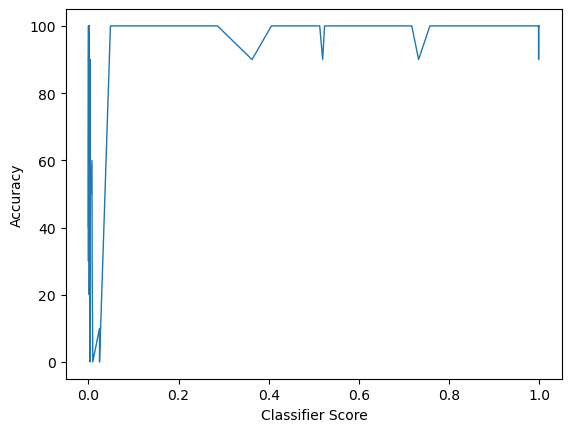

In [19]:
sub_accuracy(0.048, 10)

In [20]:
# merge_df = classification_df.merge(myDF2, left_on='Subject ID', right_on = 'Isolate ID')
# merge_df= merge_df.set_index('Isolate ID')
# merge_df = merge_df.rename(columns={"Disease": "Actual Diagnosis", 0 : "Classifier Diagnosis"})
# merge_df.loc[(merge_df['Actual Diagnosis'] == 'NCI') & (merge_df['Classifier Diagnosis'] == 'NCI'), 'Prediction'] = 'TN'
# merge_df.loc[(merge_df['Actual Diagnosis'] == 'AD') & (merge_df['Classifier Diagnosis'] == 'AD'), 'Prediction'] = 'TP'
# merge_df.loc[(merge_df['Actual Diagnosis'] == 'NCI') & (merge_df['Classifier Diagnosis'] == 'AD'), 'Prediction'] = 'FP'
# merge_df.loc[(merge_df['Actual Diagnosis'] == 'AD') & (merge_df['Classifier Diagnosis'] == 'NCI'), 'Prediction'] = 'FN'
# merge_df

In [21]:
classification_df

,0,Linear Score,Probability
Subject ID,,,
11174,AD,15.94548,1.000000
11178,NCI,-6.45882,0.001564
11182,AD,6.24588,0.998065
11186,AD,0.07776,0.519430
11190,AD,2.49161,0.923551
...,...,...,...
5683,NCI,-8.83150,0.000146
5702,NCI,-7.53024,0.000536
5706,NCI,-7.29012,0.000682


In [22]:
sorted_df = classification_df.sort_values(by="Subject ID", ascending=True)
print(sorted_df)

              0  Linear Score  Probability
Subject ID                                
11174        AD      15.94548     1.000000
11178       NCI      -6.45882     0.001564
11182        AD       6.24588     0.998065
11186        AD       0.07776     0.519430
11190        AD       2.49161     0.923551
...         ...           ...          ...
5683        NCI      -8.83150     0.000146
5702        NCI      -7.53024     0.000536
5706        NCI      -7.29012     0.000682
5767        NCI      -9.06661     0.000115
5784        NCI      -3.68194     0.024556

[243 rows x 3 columns]


In [23]:
sorted_df

,0,Linear Score,Probability
Subject ID,,,
11174,AD,15.94548,1.000000
11178,NCI,-6.45882,0.001564
11182,AD,6.24588,0.998065
11186,AD,0.07776,0.519430
11190,AD,2.49161,0.923551
...,...,...,...
5683,NCI,-8.83150,0.000146
5702,NCI,-7.53024,0.000536
5706,NCI,-7.29012,0.000682
